In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 12345
algorithm_globals.random_seed = seed

## Classification

In [10]:
dimension = 2

In [11]:
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=dimension,
    gap=0.3,
    plot_data=False, one_hot=False, include_sample_total=True
)

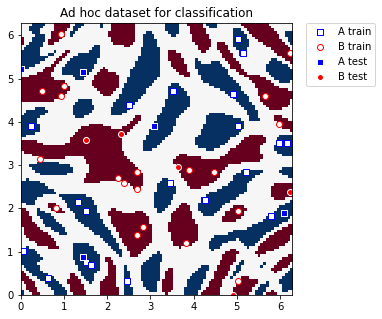

In [12]:
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(np.asmatrix(adhoc_total).T, interpolation='nearest',
           origin='lower', cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])

plt.scatter(train_features[np.where(train_labels[:] == 0), 0], train_features[np.where(train_labels[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='b', label="A train")
plt.scatter(train_features[np.where(train_labels[:] == 1), 0], train_features[np.where(train_labels[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='r', label="B train")
plt.scatter(test_features[np.where(test_labels[:] == 0), 0], test_features[np.where(test_labels[:] == 0), 1],
            marker='s', facecolors='b', edgecolors='w', label="A test")
plt.scatter(test_features[np.where(test_labels[:] == 1), 0], test_features[np.where(test_labels[:] == 1), 1],
            marker='o', facecolors='r', edgecolors='w', label="B test")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Ad hoc dataset for classification")

plt.show()

In [13]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=dimension, reps=2, entanglement='linear')

In [14]:
adhoc_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024, seed_simulator=seed, seed_transpiler=seed)

In [15]:
adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

In [16]:
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

In [18]:
adhoc_svc.fit(train_features, train_labels)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000002A27AA4B0C8>>)

In [19]:
adhoc_score = adhoc_svc.score(test_features, test_labels)

In [20]:
print(f'Callable kernel classification test score: {adhoc_score}')

Callable kernel classification test score: 1.0


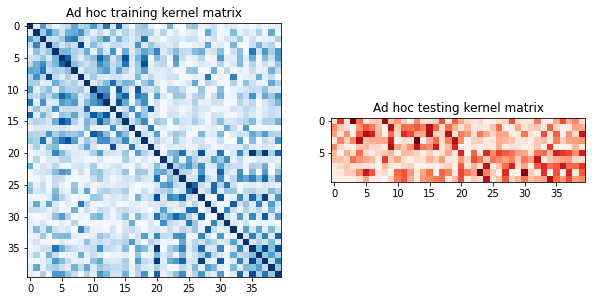

In [22]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(adhoc_matrix_train), interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("Ad hoc training kernel matrix")
axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("Ad hoc testing kernel matrix")
plt.show()

In [23]:
adhoc_svc = SVC(kernel='precomputed')
adhoc_svc.fit(adhoc_matrix_train, train_labels)
adhoc_score = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f'Precomputed kernel classification test score: {adhoc_score}')

Precomputed kernel classification test score: 1.0


In [24]:
qsvc = QSVC(quantum_kernel=adhoc_kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f'QSVC classification test score: {adhoc_score}')

QSVC classification test score: 1.0


## Clustering

In [25]:
dimension = 2

In [26]:
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=0,
    n=dimension,
    gap=0.6,
    plot_data=False, one_hot=False, include_sample_total=True
)

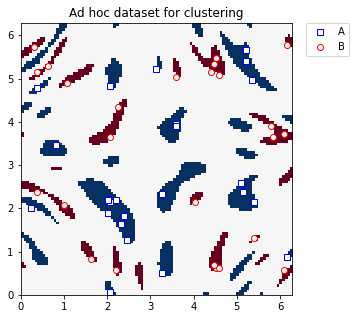

In [27]:
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(np.asmatrix(adhoc_total).T, interpolation='nearest', origin='lower', cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])
plt.scatter(train_features[np.where(train_labels[:] == 0), 0], train_features[np.where(train_labels[:] == 0), 1], marker='s', facecolors='w', edgecolors='b', label="A")
plt.scatter(train_features[np.where(train_labels[:] == 1), 0], train_features[np.where(train_labels[:] == 1), 1], marker='o', facecolors='w', edgecolors='r', label="B")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Ad hoc dataset for clustering")
plt.show()

In [31]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=dimension, reps=2, entanglement='linear')

In [32]:
adhoc_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024, seed_simulator=seed, seed_transpiler=seed)

In [33]:
adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

In [34]:
adhoc_matrix = adhoc_kernel.evaluate(x_vec=train_features)

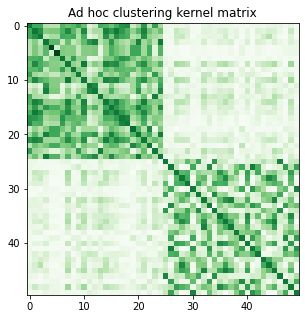

In [35]:
plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(adhoc_matrix), interpolation='nearest', origin='upper', cmap='Greens')
plt.title("Ad hoc clustering kernel matrix")
plt.show()

In [36]:
adhoc_spectral = SpectralClustering(2, affinity="precomputed")
cluster_labels = adhoc_spectral.fit_predict(adhoc_matrix)
cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)

print(f'Clustering score: {cluster_score}')

Clustering score: 1.0


In [37]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright